In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# 1. Xác định mục tiêu dự báo

- Mục tiêu: Xây dựng một mô hình phân loại (classification model) có khả năng dự đoán một khoản vay mới có khả năng trở thành "Nợ Xấu" (Bad Debt) hay không, dựa trên các thông tin của khách hàng và khoản vay tại thời điểm đăng ký.
- Giá trị kinh doanh:
    - **Giảm tỷ lệ nợ xấu**: Lọc và thẩm định kỹ hơn các hồ sơ rủi ro cao.  
    - **Tăng tốc độ duyệt vay**: Tự động hóa việc đánh giá sơ bộ cho các hồ sơ an toàn, cải thiện trải nghiệm khách hàng.  
    - **Tối ưu hóa nguồn lực**: Giúp đội ngũ thẩm định tập trung vào những ca phức tạp nhất.
- Biến mục tiêu (Target Variable): Trạng thái = 'Nợ Xấu'. Chúng ta sẽ chuyển đổi nó thành một biến nhị phân IsBadDebt (1 = Nợ Xấu, 0 = Không Nợ Xấu).


# 2. Thu thập dữ liệu lịch sử

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
# Nạp dữ liệu
df = pd.read_csv("/content/drive/MyDrive/Project_DA_TIMA/Data/Tima_CRM_Handled_Python.csv", keep_default_na=False, na_values=[])
df.shape

(1944, 55)

In [8]:
df.dtypes

,0
STT,float64
application_date,object
TS_CREDIT_SCORE_V2,float64
SoDienThoai,int64
FromDate,object
ID,float64
LoanID,float64
SoTienDKVayBanDau,float64
TienGiaiNgan,float64
TienGocConLai,float64


# 3. Làm sạch và chuẩn bị dữ liệu (Data Preparation for Modeling)

In [9]:
# --- CHUẨN BỊ DỮ LIỆU CHO MÔ HÌNH ---

# 1. Tạo biến mục tiêu (Target Variable)
df['IsBadDebt'] = np.where(df['TrangThai'] == 'Nợ Xấu', 1, 0)

In [10]:
# 2. Lựa chọn các đặc trưng (Feature Selection)
# Lựa chọn các cột có khả năng ảnh hưởng đến rủi ro
features = [
    'TS_CREDIT_SCORE_V2', 'SoTienDKVayBanDau', 'Salary', 'Gender',
    'CustomerAge', 'LongestOverdue', 'HasBadDebt', 'HasLatePayment',
    'ProductCreditName', 'CityName', 'HinhThucCuTru', 'JobName'
]
target = 'IsBadDebt'

In [11]:
# Loại bỏ các bản ghi có giá trị thiếu trong các cột quan trọng
df_model = df[features + [target]].copy()
df_model.dropna(subset=['TS_CREDIT_SCORE_V2', 'Salary', 'CustomerAge', 'LongestOverdue'], inplace=True)

In [12]:
# 3. Xác định các cột số và cột phân loại
numerical_features = ['TS_CREDIT_SCORE_V2', 'SoTienDKVayBanDau', 'Salary', 'CustomerAge', 'LongestOverdue']
categorical_features = ['Gender', 'HasBadDebt', 'HasLatePayment', 'ProductCreditName', 'CityName', 'HinhThucCuTru', 'JobName']


In [13]:
# 4. Tách dữ liệu thành tập Huấn luyện (Train) và Kiểm tra (Test)
X = df_model[features]
y = df_model[target]

In [14]:
# Sử dụng stratify=y để đảm bảo tỷ lệ Nợ Xấu trong tập train và test là như nhau
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [15]:
print("Tách dữ liệu thành công:")
print(f"Tập huấn luyện (train): {X_train.shape[0]} mẫu")
print(f"Tập kiểm tra (test): {X_test.shape[0]} mẫu")
print(f"Tỷ lệ nợ xấu trong tập huấn luyện: {y_train.mean():.2%}")
print(f"Tỷ lệ nợ xấu trong tập kiểm tra: {y_test.mean():.2%}")

Tách dữ liệu thành công:
Tập huấn luyện (train): 1555 mẫu
Tập kiểm tra (test): 389 mẫu
Tỷ lệ nợ xấu trong tập huấn luyện: 6.75%
Tỷ lệ nợ xấu trong tập kiểm tra: 6.68%


### Nhận định:
- Dữ liệu đã được làm sạch, các đặc trưng tiềm năng đã được chọn lọc và chia thành hai phần: 80% để "dạy" cho mô hình (tập train) và 20% để kiểm tra hiệu quả một cách khách quan (tập test). Việc sử dụng stratify đảm bảo mô hình được huấn luyện và kiểm tra trên các tập dữ liệu có cùng bản chất.

# 4. Khám phá và phân tích dữ liệu

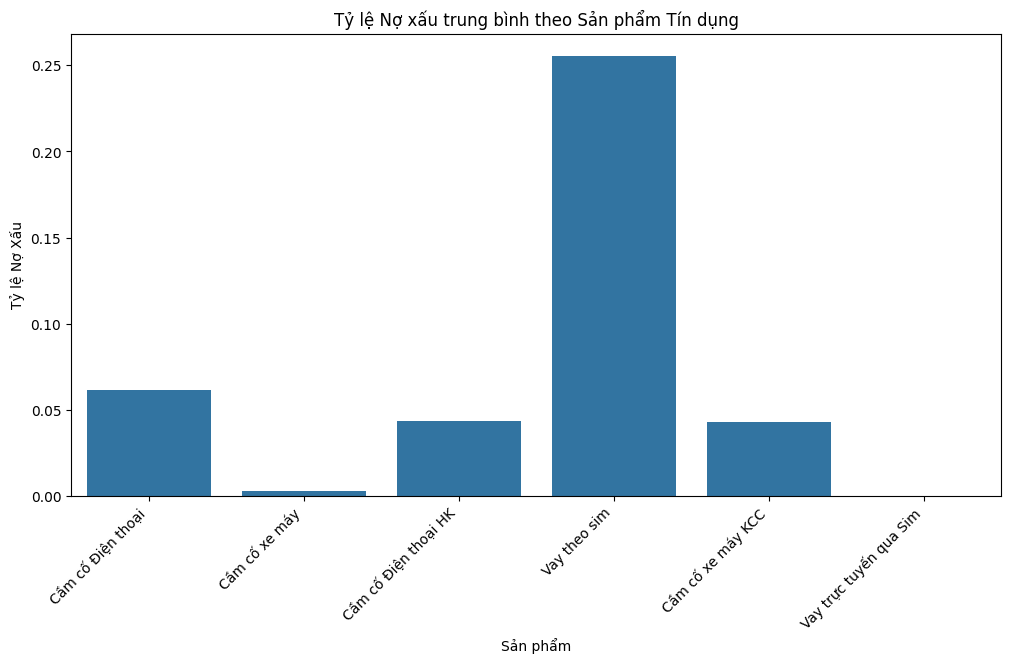

In [ ]:
# Tạo dataframe tạm để khám phá
train_df = X_train.copy()
train_df['IsBadDebt'] = y_train

# 1. Tỷ lệ nợ xấu theo sản phẩm
plt.figure(figsize=(12, 6))
sns.barplot(data=train_df, x='ProductCreditName', y='IsBadDebt', errorbar=None)
plt.title('Tỷ lệ Nợ xấu trung bình theo Sản phẩm Tín dụng')
plt.ylabel('Tỷ lệ Nợ Xấu')
plt.xlabel('Sản phẩm')
plt.xticks(rotation=45, ha='right')
plt.show()

# 2. Phân bố điểm tín dụng giữa nhóm nợ xấu và không nợ xấu
plt.figure(figsize=(10, 6))
sns.kdeplot(train_df[train_df['IsBadDebt'] == 0]['TS_CREDIT_SCORE_V2'], label='Không Nợ Xấu', fill=True)
sns.kdeplot(train_df[train_df['IsBadDebt'] == 1]['TS_CREDIT_SCORE_V2'], label='Nợ Xấu', fill=True)
plt.title('Phân bố Điểm tín dụng (TS_CREDIT_SCORE_V2) theo Tình trạng Nợ xấu')
plt.xlabel('Điểm tín dụng')
plt.legend()
plt.show()

- Sản phẩm "Vay theo sim" có tỷ lệ nợ xấu cao vượt trội so với các sản phẩm khác, khẳng định lại kết quả từ phân tích mô tả. Đây là một yếu tố rủi ro rất rõ ràng.
- Phân bố điểm tín dụng (Credit Score) cho thấy sự khác biệt rõ rệt: Nhóm khách hàng "Nợ Xấu" (màu cam) có xu hướng tập trung ở vùng điểm tín dụng thấp hơn, trong khi nhóm "Không Nợ Xấu" (màu xanh) có điểm số cao hơn. Điều này chứng tỏ TS_CREDIT_SCORE_V2 là một biến dự báo rất mạnh.

# 5. Chọn mô hình dự báo

- Mô hình được chọn: Logistic Regression.
- Lý do lựa chọn:
    1. Tính hiệu quả: Là một mô hình mạnh mẽ và phổ biến cho bài toán phân loại nhị phân.
    2. Tốc độ nhanh: Huấn luyện và dự đoán nhanh chóng, phù hợp để tích hợp vào hệ thống thời gian thực.
    3. Dễ diễn giải: Chúng ta có thể phân tích các hệ số của mô hình để hiểu được yếu tố nào đang ảnh hưởng nhiều nhất đến dự đoán rủi ro. Đây là điểm cộng rất lớn khi trình bày với các bên nghiệp vụ.
- Các lựa chọn khác: Có thể xem xét các mô hình phức tạp hơn như Random Forest hoặc Gradient Boosting trong các giai đoạn sau để cải thiện độ chính xác nếu cần.

#  6. Xây dựng và huấn luyện mô hình

In [ ]:
from sklearn.linear_model import LogisticRegression

# Tạo pipeline cho các biến số
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Tạo pipeline cho các biến phân loại
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Kết hợp hai pipeline trên bằng ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Xây dựng pipeline cuối cùng với mô hình Logistic Regression
model_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                 ('classifier', LogisticRegression(random_state=42, class_weight='balanced'))])

# Huấn luyện mô hình trên tập train
print("Bắt đầu huấn luyện mô hình...")
model_pipeline.fit(X_train, y_train)
print("Huấn luyện hoàn tất!")

# 7. Đánh giá mô hình

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

# Dự đoán trên tập test
y_pred = model_pipeline.predict(X_test)
y_pred_proba = model_pipeline.predict_proba(X_test)[:, 1] # Lấy xác suất của lớp 1 (Nợ xấu)

# 1. Ma trận nhầm lẫn (Confusion Matrix)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Không Nợ Xấu', 'Nợ Xấu'], yticklabels=['Không Nợ Xấu', 'Nợ Xấu'])
plt.ylabel('Thực tế')
plt.xlabel('Dự đoán')
plt.title('Ma trận Nhầm lẫn')
plt.show()

# 2. Báo cáo phân loại (Classification Report)
print("Báo cáo phân loại chi tiết:")
print(classification_report(y_test, y_pred, target_names=['Không Nợ Xấu', 'Nợ Xấu']))

# 3. Điểm AUC
auc_score = roc_auc_score(y_test, y_pred_proba)
print(f"Điểm ROC AUC: {auc_score:.4f}")

### Ma trận nhầm lẫn
- 288 (True Negative - TN): Có 288 khách hàng thực tế không nợ xấu và mô hình đã dự đoán đúng.
- 22 (True Positive - TP): Có 22 khách hàng thực tế có nợ xấu và mô hình đã dự đoán đúng.
- 75 (False Positive - FP): Có 75 khách hàng thực tế không nợ xấu, nhưng mô hình dự đoán nhầm là có nợ xấu. (Đây là "báo động giả").
- 4 (False Negative - FN): Có 4 khách hàng thực tế có nợ xấu, nhưng mô hình dự đoán nhầm là không có.